In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.base import BaseEstimator
from utilities.metrics import get_metric_evaluator

In [125]:
# Datasets Path
TR_PATH = "./monks/datasets/monks-1.train"
TS_PATH = "./monks/datasets/monks-1.test"

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def print_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [127]:
from collections import Counter

class KNN(BaseEstimator):
    def __init__(self, k=1, metric="manhattan"):
        self.k = k
        self.metric_evaluator = get_metric_evaluator(metric)
        self.metric = metric
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for row in X:
            label = self.closest(row)
            predictions.append(label)
        return predictions
    
    def closest(self, row):        
        distances = []

        for x_train in self.X_train:
            distances.append(self.metric_evaluator(row, x_train))

        k_indices = np.argsort(distances)[:self.k]
        k_nns_labels = []
        for i in k_indices:
            k_nns_labels.append(self.y_train[i])


        results = Counter(k_nns_labels).most_common()
        return results[0][0]
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.sum(predictions == y) / len(y)
    



In [128]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  df = pd.read_csv(path, sep=" ", names=['NaN','y','x1','x2','x3','x4','x5','x6','garbage'])
  y, df = df['y'], df.drop(columns=['NaN','garbage','y'])
  
  # One-hot encoding categorical variables
  df = pd.get_dummies(df, columns=['x1','x2','x3','x4','x5','x6']).astype('int')

  return (df, y)

In [129]:
# read training and test set
X_train, y_train = read_ds(TR_PATH)
X_test,  y_test  = read_ds(TS_PATH)

In [130]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x1_1    124 non-null    int32
 1   x1_2    124 non-null    int32
 2   x1_3    124 non-null    int32
 3   x2_1    124 non-null    int32
 4   x2_2    124 non-null    int32
 5   x2_3    124 non-null    int32
 6   x3_1    124 non-null    int32
 7   x3_2    124 non-null    int32
 8   x4_1    124 non-null    int32
 9   x4_2    124 non-null    int32
 10  x4_3    124 non-null    int32
 11  x5_1    124 non-null    int32
 12  x5_2    124 non-null    int32
 13  x5_3    124 non-null    int32
 14  x5_4    124 non-null    int32
 15  x6_1    124 non-null    int32
 16  x6_2    124 non-null    int32
dtypes: int32(17)
memory usage: 8.4 KB


In [131]:
from sklearn.model_selection import GridSearchCV, KFold


cv = KFold(n_splits=5, shuffle=True, random_state=7)
param_grid = {
    "k": [1, 3, 5, 7, 9, 11, 13, 15, 20, 30, 50],
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski","cosine"],
}
grid = GridSearchCV(KNN(), param_grid, cv=cv, n_jobs=-1)


In [132]:
grid_result = grid.fit(X_train.values, y_train.values)
knn = grid_result.best_estimator_
print(knn.get_params())

{'k': 3, 'metric': 'euclidean'}


In [133]:
#test_pred_knn_und = knn.predict(X_test)
print("Training")
print_classification_metrics(y_train,knn.predict(X_train.values))
print("Testing")
print_classification_metrics(y_test,knn.predict(X_test.values))


Training
Accuracy: 0.9113
Precision: 0.9123
Recall: 0.9113
F1 Score: 0.9112
Testing
Accuracy: 0.7917
Precision: 0.7918
Recall: 0.7917
F1 Score: 0.7916


KNN Assessment: 0.9112903225806451


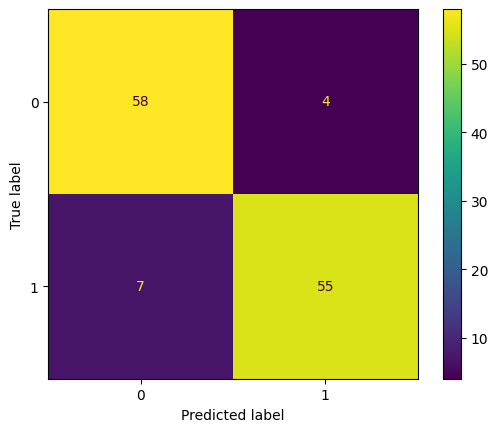

In [136]:
# Tr Confusion Matrix
print("KNN Assessment: " + str(knn.score(X_train.values, y_train.values)))

predictions = knn.predict(X_train.values)
cm = confusion_matrix(y_train.values, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


KNN Assessment: 0.7916666666666666


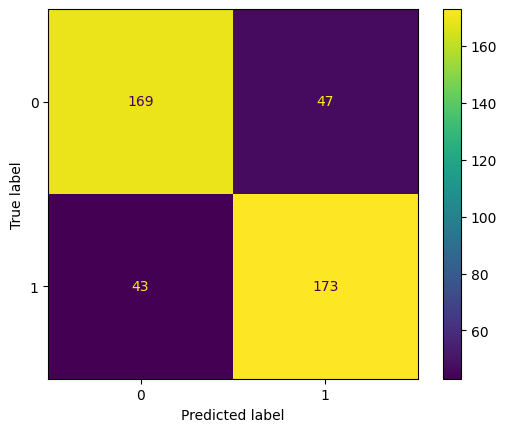

In [135]:
# Test
print("KNN Assessment: " + str(knn.score(X_test.values, y_test.values)))

# Ts Confusion Matrix
predictions = knn.predict(X_test.values)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()